In [1]:
%matplotlib inline

import math
import random

import matplotlib.pyplot as plt
import numpy as np
import numba

In [2]:
def calculate_energy(lattice, L, J):
    """Calculate the energy of a lattice using the Ising model Hamiltonian."""
    energy = 0
    for y in range(L):
        for x in range(L):
            center = lattice[y][x]
            neighbours = [(y, (x-1)%L) ,(y, (x+1)%L), ((y-1)%L, x), ((y+1)%L, x)]
            for n in neighbours:
                if lattice[n] == center:
                    energy += J
                else:
                    energy -= J # 
        
    return energy

def exponents_init(beta, J):
    exponents = {}
    for x in range(-4, 5, 2):
        exponents[2*J*x] = math.exp(-beta * 2 * J * x)
    
    return exponents

def metropolis(sweeps, temperature, bond_energy_J, lattice_size_L, initial_temperature):
    beta = 1/temperature # inverse temperature, setting Boltzmann constant to 1
    energy_history = []
    magnet_history = []
    exponents = exponents_init(beta, bond_energy_J)
    L = lattice_size_L

    if initial_temperature == "hi":
            lattice = np.random.choice([-1, 1], L*L).reshape(L, L) # infinite initial temperature
    elif initial_temperature == "lo":
        lattice = np.ones(L*L).reshape(L, L) # initial temperature is 0
    
    energy = calculate_energy(lattice, L, bond_energy_J) # calculate initial energy of the lattice
    for t in range(sweeps):
        # measurement every monte carlo timestep
        energy_history.append(energy) 
        magnet_history.append(np.sum(lattice))
        for k in range(L*L):

            rand_y, rand_x = random.randrange(L), random.randrange(L) # pick a random location on the lattice

            spin = lattice[rand_y, rand_x] # get the spin at that random location

            # determine the energy delta from flipping that spin
            neighbours = [(rand_y, (rand_x-1)%L), (rand_y, (rand_x+1)%L), ((rand_y-1)%L, rand_x), ((rand_y+1)%L, rand_x)]
            spin_sum = 0
            for n in neighbours:
                spin_sum += lattice[n]
            energy_delta = 2*bond_energy_J*spin*spin_sum
            
            
    
            if energy_delta <= 0:
                acceptance_probability = 1
            else:
                acceptance_probability = exponents[energy_delta]

            if random.random() <= acceptance_probability:
                lattice[rand_y, rand_x] = -1*spin
                energy += energy_delta

            
        if t % 1000==0:
            print("sweep", t)

    return energy_history, magnet_history

In [58]:
energy_history, magnet_history = metropolis(10000, temperature=3, bond_energy_J=1, lattice_size_L=4, initial_temperature="lo")
print(len(energy_history))

sweep 0
sweep 1000
sweep 2000
sweep 3000
sweep 4000
sweep 5000
sweep 6000
sweep 7000
sweep 8000
sweep 9000
10000


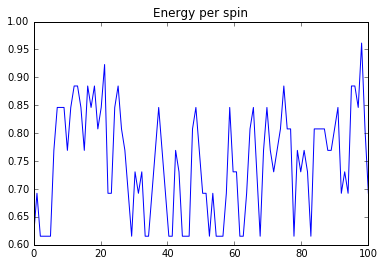

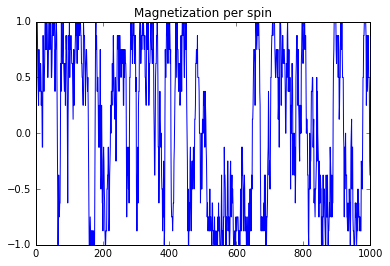

In [59]:
plt.title("Energy per spin")
cutoff = 100
plt.plot(np.linspace(0, cutoff, cutoff), [e/max(energy_history) for e in energy_history[:cutoff]])
plt.show()

plt.title("Magnetization per spin")
cutoff = 1000
plt.plot(np.linspace(0, cutoff, cutoff), [m/max(magnet_history) for m in magnet_history[:cutoff]])
plt.show()

[8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542, 8.3414442271758542,

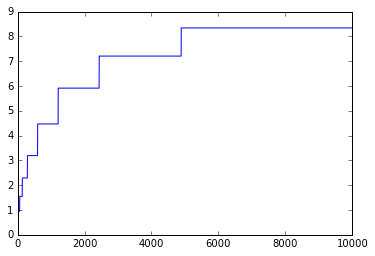

In [65]:
equilibrium = 200
equilibrium_energy = energy_history[equilibrium:] 
equilibrium_magnet = magnet_history[equilibrium:] 

def binning_method(data, min_no_bins):
    binned_data = []
    # only works if the data set has an even length
    if len(data) % 2 == 0:
        upper_bound = len(data)
    else:
        upper_bound = len(data) - 1
    for n in range(0, upper_bound, 2):
        binned_data.append(0.5*(data[n] + data[n+1]))
    if len(binned_data) > min_no_bins:
        binned_data = binning_method(binned_data, min_no_bins)[1]

    std_dev = np.std(binned_data)
#     print("hello", std_dev, "\n")
    return std_dev, binned_data


errors = []

for x in range(10000, 10, -1):
    errors.append(binning_method(equilibrium_energy, x)[0])
    
print(errors)
    
plt.plot(list(reversed(range(len(errors)))), errors)
plt.show()

binned_magnet = binning_method(equilibrium_magnet, 10)
# binned_energy = binning_method(equilibrium_energy, 64)


# plt.plot(range(len(binned_magnet)), binned_magnet)
# plt.show()

# plt.plot(range(len(binned_energy)), binned_energy)
# plt.show()

In [5]:
def auto_correlation(t, data):
    tmax = len(data)
    time_delta = data[1] - data[0]
    
    upper_bound = tmax-t
    first_sum = 0
    second_sum = 0
    third_sum = 0
    for n in range(upper_bound):
        first_sum += data[n]*data[n+t]
        second_sum += data[n]
        third_sum += data[n+t]
    
    correlation = (1/upper_bound)*(first_sum - (1/upper_bound)*second_sum*third_sum)

    return correlation



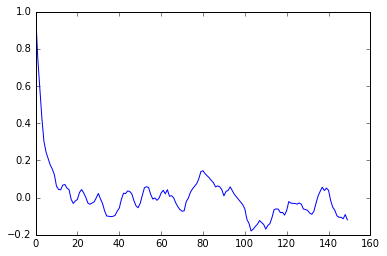

0.892294754405


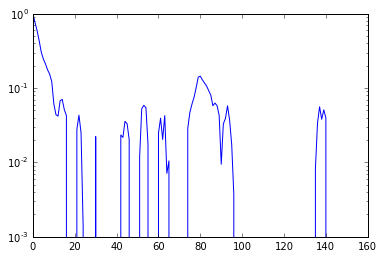

In [6]:
equilibrium = 100
data = np.asarray([auto_correlation(p, magnet_history[equilibrium:]) for p in range(0, 400-equilibrium, 2)])
normalize = data / data.max()
plt.plot(range(len(data)), normalize)
plt.show()
correlation_time = np.trapz(normalize)
print(correlation_time)

plt.plot(range(len(data)), normalize)
plt.yscale("log")
plt.show()

1999


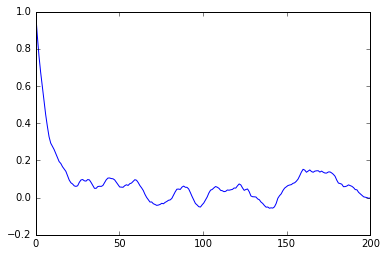

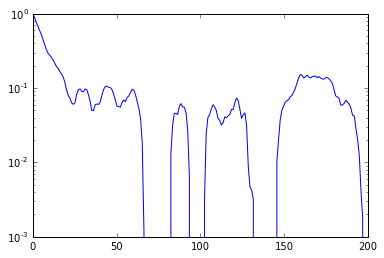

15.964833026054318

In [7]:
def numpy_autocor(data):
    data = np.asarray([d - np.mean(data) for d in data])
    acf = np.correlate(data, data, mode="full")
    return acf/acf.max()

acfunc = numpy_autocor(magnet_history)

print(len(acfunc))
# print(acfunc)

plt.plot(np.linspace(0, 200, 200), acfunc[999:1199])
plt.show()


plt.plot(np.linspace(0, 200, 200), acfunc[999:1199])
plt.yscale("log")
plt.show()
 
np.trapz(acfunc[999:1199])

In [8]:
magnet_samples = []
energy_samples = []


for t in range(equilibrium, 1000, math.ceil(2.5)):
    magnet_samples.append(magnet_history[t])
    energy_samples.append(energy_history[t])
    

    
print("absolute magnetization per spin", np.mean([math.fabs(m)/16 for m in magnet_samples]), np.std([math.fabs(m)/16 for m in magnet_samples]))
print("magnetization per spin", np.mean(magnet_samples)/16, np.std(magnet_samples)/16)
print("energy per spin", np.mean(energy_samples)/16, np.std(energy_samples)/16)
print("magnetization squared", np.mean([x**2 for x in magnet_samples]), np.std([x**2 for x in magnet_samples]))
    
    
    

absolute magnetization per spin 0.58125 0.309422344862
magnetization per spin 0.30125 0.585527273062
energy per spin 5.00666666667 0.576950797055
magnetization squared 111.0 86.9471103603


TEMPERATURE 0.2
sweep 0


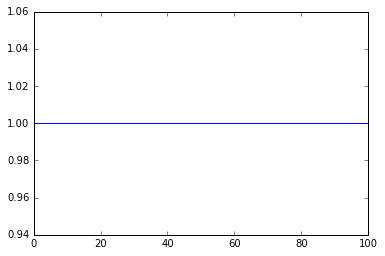

/Users/Teun/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


1999
[ nan  nan  nan ...,  nan  nan  nan]
No valid auto correlation function.
correlation_time 4
TEMPERATURE 0.4
sweep 0


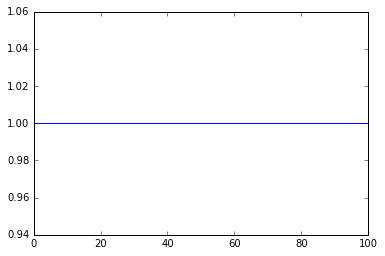

1999
[ nan  nan  nan ...,  nan  nan  nan]
No valid auto correlation function.
correlation_time 4
TEMPERATURE 0.6
sweep 0


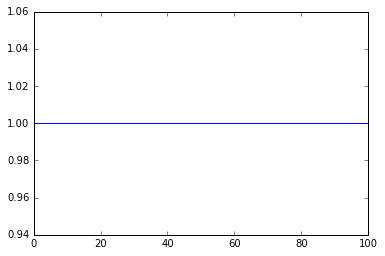

1999
[ nan  nan  nan ...,  nan  nan  nan]
No valid auto correlation function.
correlation_time 4
TEMPERATURE 0.8
sweep 0


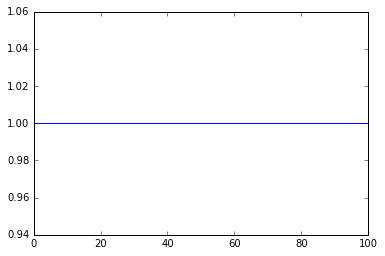

1999
[ nan  nan  nan ...,  nan  nan  nan]
No valid auto correlation function.
correlation_time 4
TEMPERATURE 1.0
sweep 0


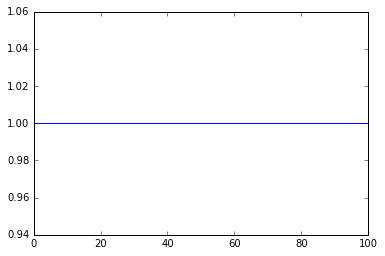

1999
[  4.01606426e-06   8.03212851e-06   1.20481928e-05 ...,   1.20481928e-05
   8.03212851e-06   4.01606426e-06]
correlation_time -2.00803212813e-06
Had to change correlation time.
TEMPERATURE 1.2
sweep 0


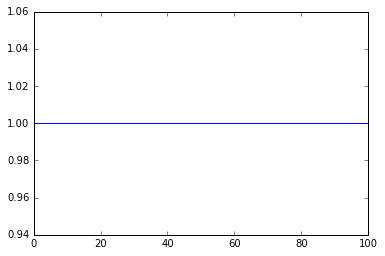

1999
[  2.59836320e-05   5.19672640e-05   7.79508959e-05 ...,   7.79508959e-05
   5.19672640e-05   2.59836320e-05]
correlation_time -1.29918159974e-05
Had to change correlation time.
TEMPERATURE 1.4
sweep 0


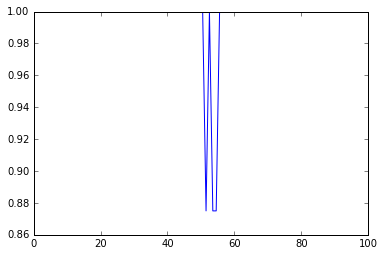

1999
[-0.00082895 -0.00165791 -0.00248686 ..., -0.00248686 -0.00165791
 -0.00082895]
correlation_time 0.000414476309934
TEMPERATURE 1.6
sweep 0


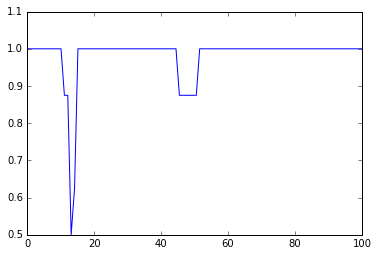

1999
[  8.66851180e-05   1.73370236e-04   2.60055354e-04 ...,   2.60055354e-04
   1.73370236e-04   8.66851180e-05]
correlation_time -4.33425590096e-05
Had to change correlation time.
TEMPERATURE 1.8
sweep 0


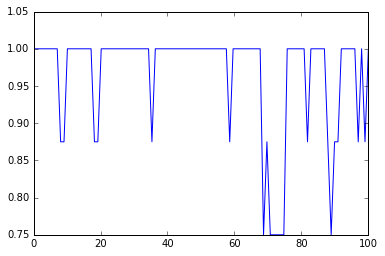

1999
[ 0.00013494  0.00026989  0.00040483 ...,  0.00040483  0.00026989
  0.00013494]
correlation_time -6.74723998961e-05
Had to change correlation time.
TEMPERATURE 2.0
sweep 0


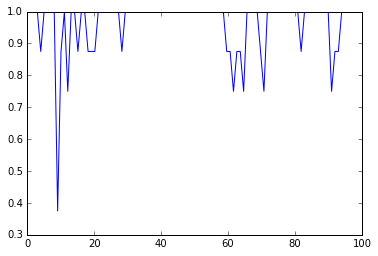

1999
[-0.00111288 -0.0021186  -0.00323148 ..., -0.00323148 -0.0021186
 -0.00111288]
correlation_time 0.000556442286879
TEMPERATURE 2.2
sweep 0


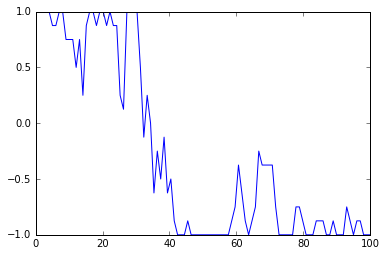

1999
[ 0.00073519  0.0016132   0.00263401 ...,  0.00263401  0.0016132
  0.00073519]
correlation_time -0.000367596034333
Had to change correlation time.
TEMPERATURE 2.4
sweep 0


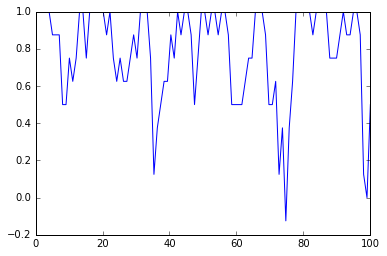

1999
[ 0.00051471  0.00102941  0.00154412 ...,  0.00154412  0.00102941
  0.00051471]
correlation_time -0.000257353347396
Had to change correlation time.
TEMPERATURE 2.6
sweep 0


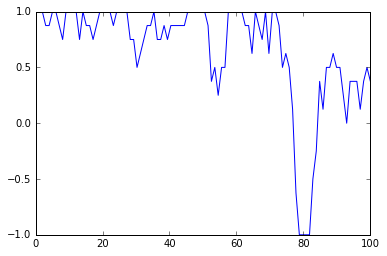

1999
[-0.00040569 -0.00140944 -0.00281191 ..., -0.00281191 -0.00140944
 -0.00040569]
correlation_time 0.000202844099222
TEMPERATURE 2.8
sweep 0


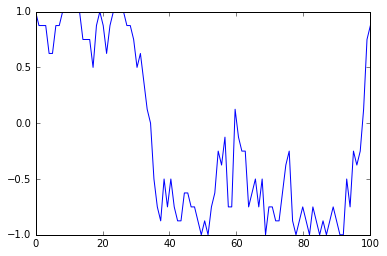

1999
[ 0.00152909  0.0026181   0.0034719  ...,  0.0034719   0.0026181
  0.00152909]
correlation_time -0.000764545831274
Had to change correlation time.
TEMPERATURE 3.0
sweep 0


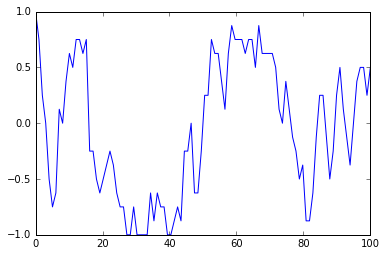

1999
[ 0.00211953  0.00481264  0.00531097 ...,  0.00531097  0.00481264
  0.00211953]
correlation_time -0.0010597639307
Had to change correlation time.
TEMPERATURE 3.2
sweep 0


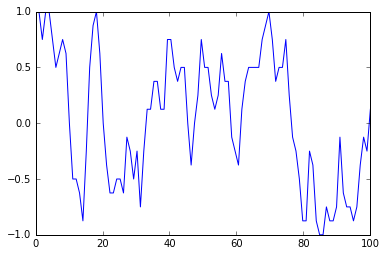

1999
[-0.00217981 -0.00323412 -0.00312461 ..., -0.00312461 -0.00323412
 -0.00217981]
correlation_time 0.00108990593587
TEMPERATURE 3.4
sweep 0


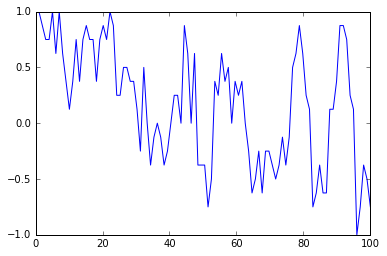

1999
[-0.00090957 -0.00215701 -0.00361787 ..., -0.00361787 -0.00215701
 -0.00090957]
correlation_time 0.000454783214648
TEMPERATURE 3.6
sweep 0


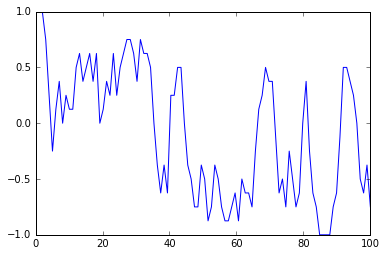

1999
[ 0.00232826  0.00505302  0.00738128 ...,  0.00738128  0.00505302
  0.00232826]
correlation_time -0.00116413010103
Had to change correlation time.
TEMPERATURE 3.8
sweep 0


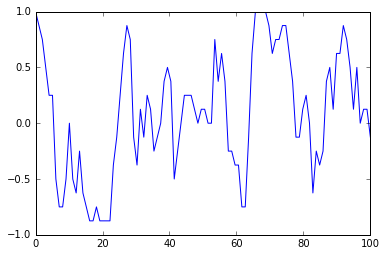

1999
[-0.00233799 -0.00393644 -0.00528305 ..., -0.00528305 -0.00393644
 -0.00233799]
correlation_time 0.00116899255354
TEMPERATURE 4.0
sweep 0


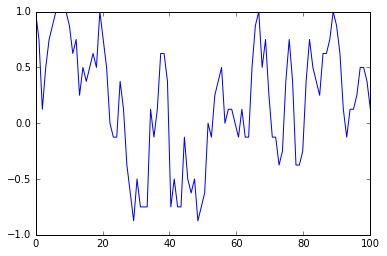

1999
[ 0.00152708  0.00365454  0.00460256 ...,  0.00460256  0.00365454
  0.00152708]
correlation_time -0.000763541449844
Had to change correlation time.
TEMPERATURE 4.2
sweep 0


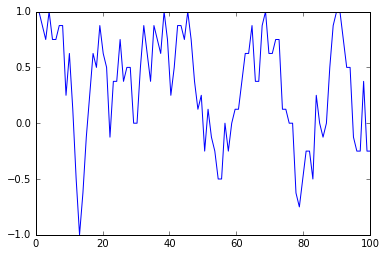

1999
[-0.00210007 -0.00420013 -0.00602817 ..., -0.00602817 -0.00420013
 -0.00210007]
correlation_time 0.00105003305028
TEMPERATURE 4.4
sweep 0


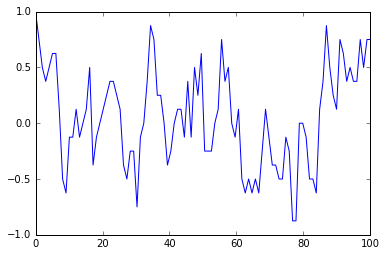

1999
[ 0.00222347  0.00208997 -0.00172258 ..., -0.00172258  0.00208997
  0.00222347]
correlation_time -0.00111173515109
Had to change correlation time.
TEMPERATURE 4.6
sweep 0


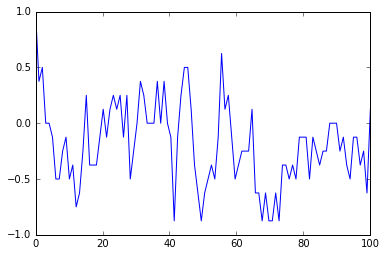

1999
[ -3.44204236e-05  -2.42099329e-03  -3.91088183e-03 ...,  -3.91088183e-03
  -2.42099329e-03  -3.44204236e-05]
correlation_time 1.72102118021e-05
TEMPERATURE 4.8
sweep 0


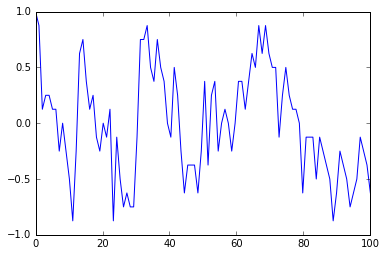

1999
[-0.00183239 -0.00079236  0.00391096 ...,  0.00391096 -0.00079236
 -0.00183239]
correlation_time 0.000916195868386
TEMPERATURE 5.0
sweep 0


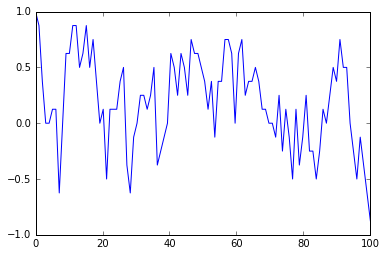

1999
[-0.00091165 -0.00170654 -0.00432881 ..., -0.00432881 -0.00170654
 -0.00091165]
correlation_time 0.000455823881677
TEMPERATURE 5.2
sweep 0


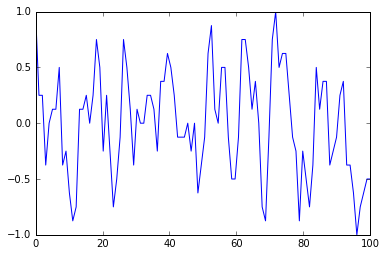

1999
[-0.00338098 -0.00217412 -0.00110374 ..., -0.00110374 -0.00217412
 -0.00338098]
correlation_time 0.00169048805885
TEMPERATURE 5.4
sweep 0


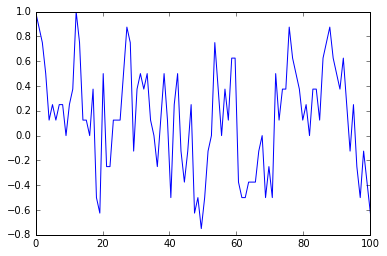

1999
[ 0.00207754  0.00389073  0.00325957 ...,  0.00325957  0.00389073
  0.00207754]
correlation_time -0.0010387717879
Had to change correlation time.
TEMPERATURE 5.6
sweep 0


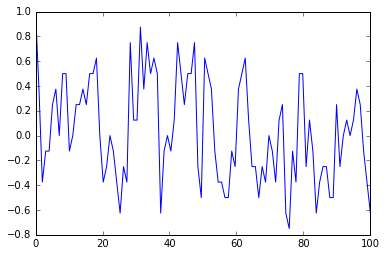

1999
[-0.00160901 -0.00462591 -0.00492759 ..., -0.00492759 -0.00462591
 -0.00160901]
correlation_time 0.000804505229284
TEMPERATURE 5.8
sweep 0


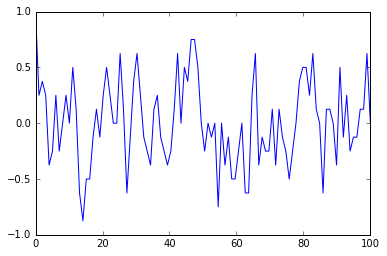

1999
[ 0.00093897 -0.00229698 -0.00370371 ..., -0.00370371 -0.00229698
  0.00093897]
correlation_time -0.000469484376347
Had to change correlation time.
TEMPERATURE 6.0
sweep 0


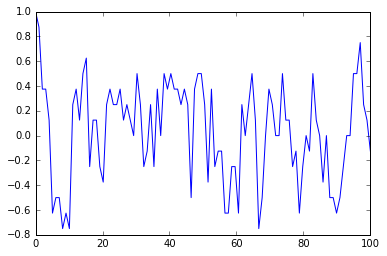

1999
[ 0.00272246  0.0023456  -0.00181005 ..., -0.00181005  0.0023456
  0.00272246]
correlation_time -0.00136122894906
Had to change correlation time.
TEMPERATURE 6.2
sweep 0


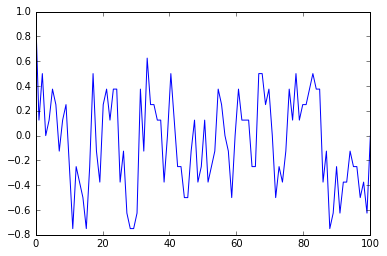

1999
[-0.00084034  0.00274819 -0.0018046  ..., -0.0018046   0.00274819
 -0.00084034]
correlation_time 0.000420169597284
TEMPERATURE 6.4
sweep 0


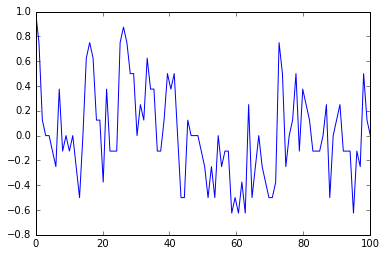

1999
[ 0.00083544 -0.00201638 -0.0045193  ..., -0.0045193  -0.00201638
  0.00083544]
correlation_time -0.000417719822235
Had to change correlation time.
TEMPERATURE 6.6
sweep 0


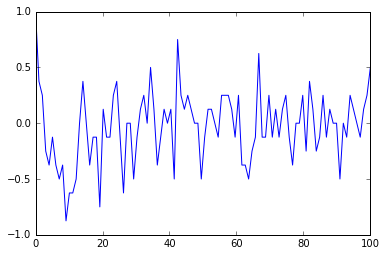

1999
[ 0.00394069  0.00541259 -0.0005384  ..., -0.0005384   0.00541259
  0.00394069]
correlation_time -0.00197034500739
Had to change correlation time.
TEMPERATURE 6.8
sweep 0


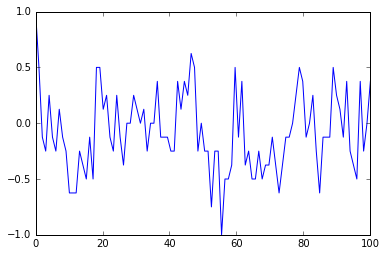

1999
[ 0.00510919  0.00563895  0.00196598 ...,  0.00196598  0.00563895
  0.00510919]
correlation_time -0.00255459281975
Had to change correlation time.
TEMPERATURE 7.0
sweep 0


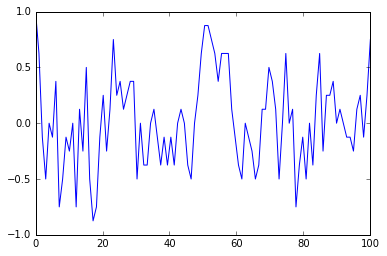

1999
[ 0.00350527  0.00478581  0.00016491 ...,  0.00016491  0.00478581
  0.00350527]
correlation_time -0.00175263547086
Had to change correlation time.
TEMPERATURE 7.2
sweep 0


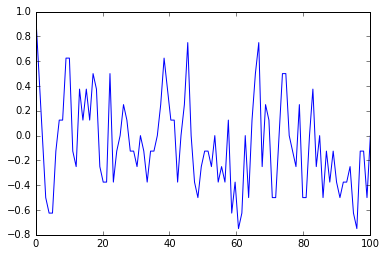

1999
[ 0.00112199 -0.00031228 -0.0003105  ..., -0.0003105  -0.00031228
  0.00112199]
correlation_time -0.000560994867747
Had to change correlation time.
TEMPERATURE 7.4
sweep 0


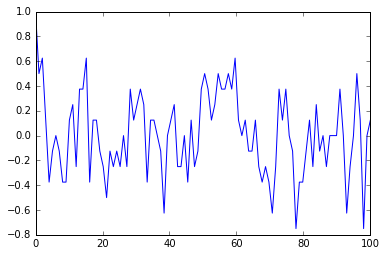

1999
[ 0.00559504  0.001492    0.00500715 ...,  0.00500715  0.001492    0.00559504]
correlation_time -0.0027975205845
Had to change correlation time.
TEMPERATURE 7.6
sweep 0


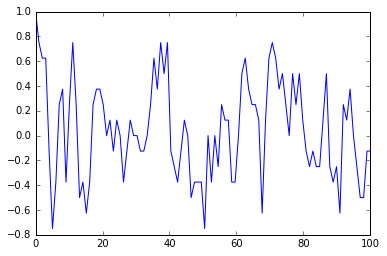

1999
[-0.00625761 -0.00887961 -0.00610118 ..., -0.00610118 -0.00887961
 -0.00625761]
correlation_time 0.00312880576961
TEMPERATURE 7.8
sweep 0


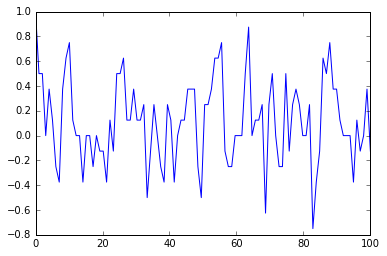

1999
[ 0.00208664  0.00312194  0.00415725 ...,  0.00415725  0.00312194
  0.00208664]
correlation_time -0.00104331969823
Had to change correlation time.
TEMPERATURE 8.0
sweep 0


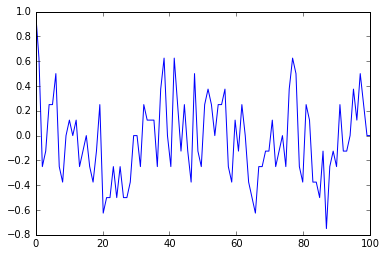

1999
[-0.00536561 -0.00658377  0.00354668 ...,  0.00354668 -0.00658377
 -0.00536561]
correlation_time 0.00268280501327
TEMPERATURE 8.2
sweep 0


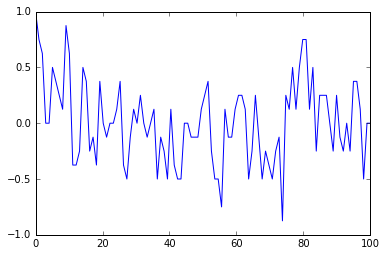

1999
[ 0.00439884  0.00771048  0.00832854 ...,  0.00832854  0.00771048
  0.00439884]
correlation_time -0.00219942249363
Had to change correlation time.
TEMPERATURE 8.4
sweep 0


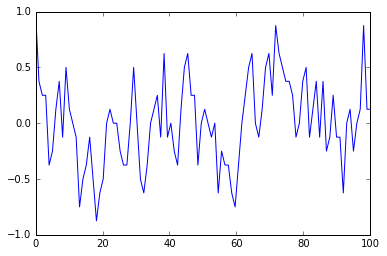

1999
[ 0.00476667 -0.00028055  0.00520377 ...,  0.00520377 -0.00028055
  0.00476667]
correlation_time -0.00238333702676
Had to change correlation time.
TEMPERATURE 8.6
sweep 0


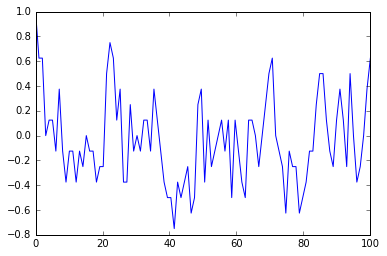

1999
[ 0.00491065  0.00802297  0.00996385 ...,  0.00996385  0.00802297
  0.00491065]
correlation_time -0.00245532648013
Had to change correlation time.
TEMPERATURE 8.8
sweep 0


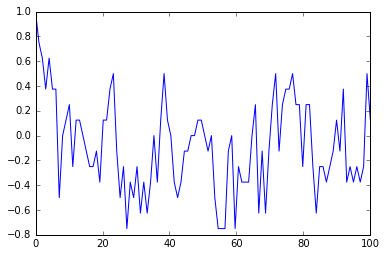

1999
[ 0.0013108   0.00350869  0.00403314 ...,  0.00403314  0.00350869
  0.0013108 ]
correlation_time -0.00065540115564
Had to change correlation time.
TEMPERATURE 9.0
sweep 0


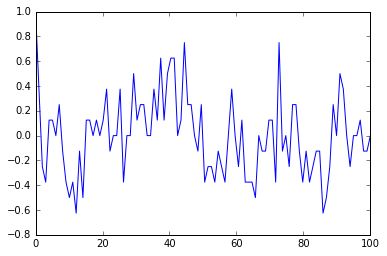

1999
[ 0.00368457 -0.00079143 -0.00155094 ..., -0.00155094 -0.00079143
  0.00368457]
correlation_time -0.001842284531
Had to change correlation time.
TEMPERATURE 9.2
sweep 0


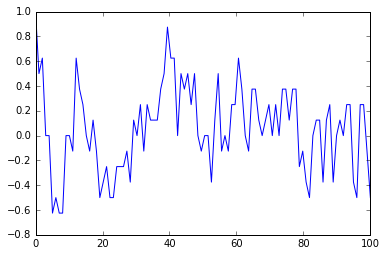

1999
[-0.00362412 -0.00296553 -0.00896807 ..., -0.00896807 -0.00296553
 -0.00362412]
correlation_time 0.00181205837528
TEMPERATURE 9.4
sweep 0


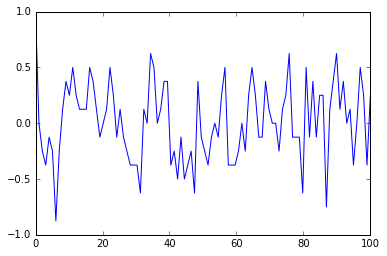

1999
[-0.00125926 -0.00241875  0.00377908 ...,  0.00377908 -0.00241875
 -0.00125926]
correlation_time 0.0006296306561
TEMPERATURE 9.6
sweep 0


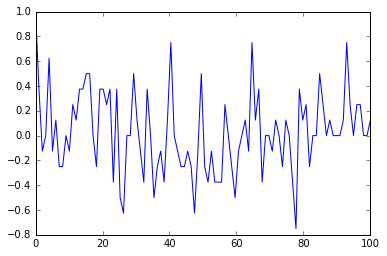

1999
[-0.00241006  0.00046205  0.00091741 ...,  0.00091741  0.00046205
 -0.00241006]
correlation_time 0.00120502802303
TEMPERATURE 9.8
sweep 0


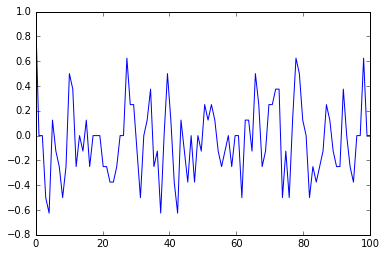

1999
[ 0.00293971  0.00434358 -0.0008506  ..., -0.0008506   0.00434358
  0.00293971]
correlation_time -0.00146985667193
Had to change correlation time.


In [10]:
temp_dep_energy = []
temp_dep_energy_error = []
temp_dep_magnet = []
temp_dep_magnet_error = []

lattice_L = 4

for T in np.arange(0.2, 10.0, 0.2):
    print("TEMPERATURE", T)
    magnet_samples = []
    energy_samples = []
    energy_history, magnet_history = metropolis(1000, temperature=T, bond_energy_J=1, lattice_size_L=lattice_L, initial_temperature="lo")
    plt.plot(np.linspace(0,100, 100), [m/max(magnet_history) for m in magnet_history[:100]])
    plt.show()
    acf = numpy_autocor(magnet_history)
    
    print(len(acf))
    print(acf)
    if np.isnan(acf).any():
        print("No valid auto correlation function.")
        correlation_time = 4
    else:
        correlation_time = np.trapz(acf[999:])
        
    
    print("correlation_time", correlation_time)
    if correlation_time <= 0:
        correlation_time = 4
        print("Had to change correlation time.")
    for t in range(equilibrium, 1000, math.ceil(correlation_time)):
        magnet_samples.append(magnet_history[t])
        energy_samples.append(energy_history[t])

    temp_dep_energy.append(np.mean([math.fabs(m)/lattice_L**2 for m in energy_samples]))
    temp_dep_energy_error.append(np.std([math.fabs(m)/lattice_L**2 for m in energy_samples]))
    
    temp_dep_magnet.append(np.mean([math.fabs(m)/lattice_L**2 for m in magnet_samples]))
    temp_dep_magnet_error.append(np.std([math.fabs(m)/lattice_L**2 for m in magnet_samples]))
    
    
    

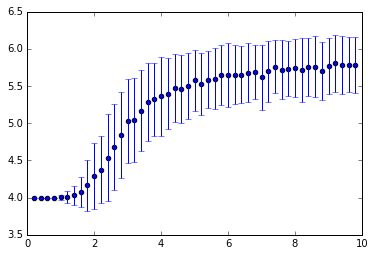

In [11]:
# plt.plot(np.arange(0.2, 5.0, 0.2), temp_dep_energy)
plt.xlim(0, 10)
plt.scatter(np.arange(0.2, 10.0, 0.2), temp_dep_energy)
plt.errorbar(np.arange(0.2, 10.0, 0.2), temp_dep_energy, temp_dep_energy_error, linestyle='None')
plt.show()

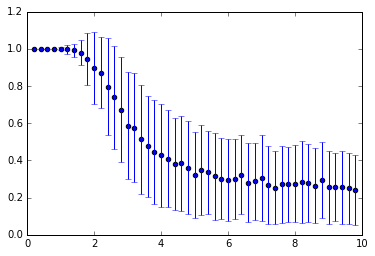

In [12]:
# plt.plot(np.arange(0.2, 5.0, 0.2), temp_dep_magnet)
plt.xlim(0, 10)
plt.scatter(np.arange(0.2, 10.0, 0.2), temp_dep_magnet)
plt.errorbar(np.arange(0.2, 10.0, 0.2),  temp_dep_magnet, temp_dep_magnet_error, linestyle='None')
plt.show()

/Users/Teun/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


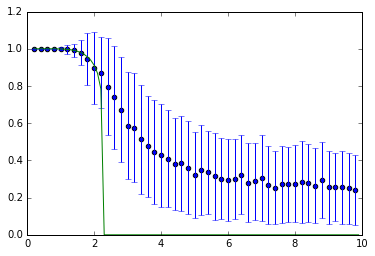

In [17]:
def magnetizability(T):
    M = (1 - np.sinh(2*(1/T)*1)**(-4))**(1/8)
    if math.isnan(M):
        return 0
    

    return M


exact_magnet = [magnetizability(T) for T in np.arange(0.2, 10, 0.1)]

plt.xlim(0, 10)
plt.ylim(0, 1.2)

plt.scatter(np.arange(0.2, 10.0, 0.2), temp_dep_magnet)
plt.errorbar(np.arange(0.2, 10.0, 0.2),  temp_dep_magnet, temp_dep_magnet_error, linestyle='None')
plt.plot(np.arange(0.2, 10, 0.1), exact_magnet)
plt.show()

In [ ]:
import scipy.special
def energy(T):
    J = -1
    k = 2 * np.sinh(2*(1/T)*-J)/(np.cosh(2*(1/T)*J))**2
    energy = J * (1/np.tanh(2*(1/T)*J)) * (1 + (2*np.tanh(2*(1/T)*J) - 1)* (2/np.pi) * scipy.special.ellipk(k))
    return energy

In [ ]:
exact_energy = [energy(T) for T in np.arange(0.2, 10, 0.1)]
plt.plot(np.arange(0.2, 10, 0.1), exact_energy)

plt.xlim(0, 10)
plt.scatter(np.arange(0.2, 10.0, 0.2), temp_dep_energy)
plt.errorbar(np.arange(0.2, 10.0, 0.2), temp_dep_energy, temp_dep_energy_error, linestyle='None')
plt.show()